In [14]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib
import statistics
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import math
import glob
from itertools import combinations
from matplotlib import pyplot as plt
from Bio import Phylo
import biotite
from pca_plot import *
from stattools.resampling import PermutationTest
from matplotlib_venn import venn2


In [15]:
chm13 = pd.read_csv('/Users/luciabazan/Downloads/chm13_gene_regions.csv', index_col=0)
chm13['LENGHT'] = chm13['END'] - chm13['START']
chm13 = chm13.drop(columns=['START_GENE', 'END_GENE'])
chm13 = chm13.drop_duplicates()
#chm13 = chm13[chm13['SCORE'] < 5]
chm13#['TYPE'].value_counts()

,SAMPLE,CHR,START,END,SCORE,TYPE,LENGHT
0,LP6005441-DNA_B02,chrX,105118,116978,1,DELETION,11860
18,LP6005441-DNA_B02,chrX,1038532,1048096,1,DELETION,9564
21,LP6005441-DNA_B02,chrX,1193541,1202443,1,DELETION,8902
24,LP6005441-DNA_B02,chrX,1296349,1304923,1,DELETION,8574
26,LP6005441-DNA_B02,chrX,1855267,1863572,1,DELETION,8305
...,...,...,...,...,...,...,...
1874421,LP6005442-DNA_H01,chr1,247606647,247620901,5,DUPLICATION,14254
1874427,LP6005442-DNA_H01,chr1,247629795,247637933,4,DUPLICATION,8138
1874430,LP6005442-DNA_H01,chr1,247738073,247750886,6,DUPLICATION,12813
1874432,LP6005442-DNA_H01,chr1,247954331,247967419,4,DUPLICATION,13088


In [16]:
## Read and merge files 
anotation = pd.read_csv('../data/SGDP_anotation.csv', sep=',', encoding='latin-1')

ids_hg19 = pd.DataFrame()
ids_hg19['SAMPLE'] = anotation['3-Illumina_ID']
ids_hg19['REGION'] = anotation['10-Region']
ids_hg19['COUNTRY'] = anotation['11-Country']

In [17]:
#change to df when using telomeres and centromeres filtration
cnv = chm13.pivot_table(index=["CHR", "START", "END"], 
                    columns='SAMPLE', 
                    values='SCORE').reset_index()


cnv

SAMPLE,CHR,START,END,LP6005441-DNA_A01,LP6005441-DNA_A03,LP6005441-DNA_A04,LP6005441-DNA_A05,LP6005441-DNA_A06,LP6005441-DNA_A08,LP6005441-DNA_A09,...,LP6005677-DNA_D03,LP6005677-DNA_E01,LP6005677-DNA_F01,LP6005677-DNA_G01,LP6007068-DNA_A01,LP6007069-DNA_A01,SS6004471,SS6004477,SS6004478,SS6004480
0,chr1,102061,111943,12.0,15.0,11.0,14.0,15.0,12.0,11.0,...,15.0,13.0,14.0,14.0,14.0,12.0,15.0,11.0,13.0,16.0
1,chr1,521722,540598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0
2,chr1,613436,625116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,839350,851555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
4,chr1,1041679,1050074,NaN,NaN,1.0,1.0,NaN,1.0,NaN,...,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10743,chrY,26436587,26458551,5.0,0.0,0.0,4.0,4.0,3.0,NaN,...,0.0,4.0,0.0,4.0,4.0,0.0,3.0,4.0,0.0,4.0
10744,chrY,26778516,26788355,4.0,0.0,0.0,3.0,3.0,4.0,NaN,...,0.0,3.0,0.0,4.0,4.0,0.0,3.0,3.0,0.0,4.0
10745,chrY,62325695,62345374,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10746,chrY,62345374,62363313,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
coordinates = cnv.iloc[:,0:2]
cnvs = cnv.iloc[:,3:284]
cnvs = cnvs.T
cnvs = cnvs.fillna(2)
cnvs

,0,1,2,3,4,5,6,7,8,9,...,10738,10739,10740,10741,10742,10743,10744,10745,10746,10747
SAMPLE,,,,,,,,,,,,,,,,,,,,,
LP6005441-DNA_A01,12.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,...,3.0,4.0,4.0,4.0,3.0,5.0,4.0,2.0,2.0,2.0
LP6005441-DNA_A03,15.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0
LP6005441-DNA_A04,11.0,2.0,2.0,2.0,1.0,3.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0
LP6005441-DNA_A05,14.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,...,2.0,3.0,3.0,3.0,2.0,4.0,3.0,2.0,2.0,2.0
LP6005441-DNA_A06,15.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,...,2.0,3.0,3.0,3.0,3.0,4.0,3.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LP6007069-DNA_A01,12.0,2.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0
SS6004471,15.0,1.0,2.0,2.0,1.0,3.0,1.0,2.0,2.0,2.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0
SS6004477,11.0,2.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,2.0,...,2.0,3.0,3.0,4.0,3.0,4.0,3.0,2.0,2.0,2.0


In [19]:
dt = ids_hg19.set_index('SAMPLE').merge(cnvs, left_index=True, right_index=True)
dt = dt.sort_index()
features = dt.loc[:,['REGION', 'COUNTRY']]
features = features.sort_index()

In [20]:
####### Groupby regions #######
dt_group = dt.groupby('REGION')

dt_groupped = []
regions = features['REGION'].unique()
print(regions)
for i in regions:
    dt_groupped.append(dt_group.get_group(str(i)))
    

#### Names to pair-population
regions = dt['REGION'].unique()
print(regions)
combination_names = []
for i in list(combinations(regions,2)):
    combination_names.append(i[0]+str('-')+i[1])
    


['WestEurasia' 'Oceania' 'America' 'Africa' 'EastAsia' 'SouthAsia'
 'CentralAsiaSiberia']
['WestEurasia' 'Oceania' 'America' 'Africa' 'EastAsia' 'SouthAsia'
 'CentralAsiaSiberia']


In [21]:
####### Groupby regions #######
dt_group = dt.groupby('REGION')

dt_groupped = []
regions = features['REGION'].unique()
for i in regions:
    dt_groupped.append(dt_group.get_group(str(i)))
    

#### Names to pair-population
regions = dt['REGION'].unique()
combination_names = []
for i in list(combinations(regions,2)):
    combination_names.append(i[0]+str('-')+i[1])
    


In [22]:
dt_groupped

[                        REGION           COUNTRY     0    1    2    3    4  \
 SAMPLE                                                                       
 LP6005441-DNA_A01  WestEurasia  Russia(Caucasus)  12.0  2.0  2.0  2.0  2.0   
 LP6005441-DNA_A05  WestEurasia            France  14.0  2.0  2.0  2.0  1.0   
 LP6005441-DNA_A06  WestEurasia    Italy(Bergamo)  15.0  2.0  2.0  2.0  2.0   
 LP6005441-DNA_B01  WestEurasia  Russia(Caucasus)  15.0  2.0  2.0  2.0  2.0   
 LP6005441-DNA_B05  WestEurasia            France  16.0  2.0  2.0  2.0  2.0   
 ...                        ...               ...   ...  ...  ...  ...  ...   
 LP6005677-DNA_A03  WestEurasia            Turkey  13.0  2.0  2.0  2.0  1.0   
 LP6005677-DNA_B01  WestEurasia           Albania  14.0  1.0  2.0  2.0  1.0   
 LP6005677-DNA_C03  WestEurasia            Turkey  15.0  2.0  2.0  2.0  2.0   
 LP6007068-DNA_A01  WestEurasia            Greece  14.0  2.0  2.0  2.0  1.0   
 LP6007069-DNA_A01  WestEurasia            Greece  1

In [23]:
## VST for pair-population

from vst_function import *
vst_dt = []

combination_regions = list(combinations([0,1,2,3,4,5,6],2))
for region in combination_regions:
        statistic = vst((dt_groupped[region[0]]), (dt_groupped[region[1]]))
        vst_dt.append(statistic)

vst_dt = pd.DataFrame(vst_dt).set_axis(combination_names)
#vst_dt = vst_dt.T
vst_dt

/Users/luciabazan/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3713: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/luciabazan/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3713: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/luciabazan/Documents/GitHub/cnv_sgdp/scripts/vst_function.py:33: FutureWarning: The default value of numeric_only in DataFrame.va

,0,1,2,3,4,5,6,7,8,9,...,10738,10739,10740,10741,10742,10743,10744,10745,10746,10747
WestEurasia-Oceania,0.018341,0.051059,NaN,0.011431,0.032919,0.211830,0.018174,0.026963,0.013699,NaN,...,0.011049,0.014368,0.010634,0.010957,0.013532,0.015718,0.016524,0.013699,0.013699,0.017159
WestEurasia-America,0.030527,0.011290,NaN,0.034343,0.011314,0.010878,0.015387,0.015938,0.013699,NaN,...,0.019031,0.037490,0.029717,0.025666,0.033569,0.032367,0.053015,0.013699,0.013699,0.016709
WestEurasia-Africa,0.106892,0.026284,NaN,0.035764,0.009836,0.008914,0.012906,0.012066,0.013699,0.040287,...,0.016610,0.012335,0.016269,0.014630,0.009739,0.009910,0.013250,0.013699,0.013699,0.018713
WestEurasia-EastAsia,0.053486,0.008431,0.021739,0.010159,0.016229,0.013078,0.008636,0.008846,0.013699,0.021739,...,0.017906,0.017626,0.021756,0.020667,0.032477,0.022732,0.020829,0.009323,0.009323,0.008710
WestEurasia-SouthAsia,0.139888,0.009650,NaN,0.016641,0.031034,0.011604,0.036289,0.009065,0.045439,0.026316,...,0.045856,0.034583,0.034854,0.034127,0.034310,0.027913,0.044059,0.013699,0.011016,0.009019
WestEurasia-CentralAsiaSiberia,0.045162,0.026437,NaN,0.024486,0.026242,0.011974,0.028864,0.011155,0.013699,NaN,...,0.068812,0.052202,0.085663,0.088231,0.070584,0.055544,0.052083,0.061000,0.061000,0.017473
Oceania-America,0.027853,0.058375,NaN,0.078571,0.068333,0.258437,0.059375,0.083034,NaN,NaN,...,0.028203,0.038188,0.041869,0.034977,0.036940,0.032124,0.048885,NaN,NaN,NaN
Oceania-Africa,0.177461,0.022490,NaN,0.053179,0.035647,0.291658,0.016585,0.025474,NaN,0.033682,...,0.028906,0.032129,0.026887,0.026288,0.024735,0.029184,0.038507,NaN,NaN,NaN
Oceania-EastAsia,0.027726,0.063124,0.021739,NaN,0.022091,0.229167,0.028340,0.041079,NaN,0.021739,...,0.018641,0.014933,0.023273,0.020600,0.023021,0.015739,0.014851,0.021739,0.021739,0.021739
Oceania-SouthAsia,0.105252,0.076120,NaN,0.036842,0.112390,0.208019,0.021033,0.037718,0.036842,0.026316,...,0.068615,0.073444,0.052900,0.052606,0.071957,0.072104,0.095339,NaN,0.026316,0.026316


In [24]:
filtering_vst = pd.DataFrame(vst_dt)>=0.2
filtering_vst = filtering_vst.loc[:, filtering_vst.any()]
#filtering_vst = filtering_vst.set_axis(combination_names)
filtering_vst

,0,5,30,35,52,62,63,76,81,101,...,10722,10723,10733,10734,10735,10736,10737,10738,10740,10741
WestEurasia-Oceania,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-America,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-Africa,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-EastAsia,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-SouthAsia,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WestEurasia-CentralAsiaSiberia,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
Oceania-America,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Oceania-Africa,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Oceania-EastAsia,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Oceania-SouthAsia,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [25]:
## Coordinates anotation 
vst_dt = vst_dt.T
vst_dt.insert (0, 'CHR', cnv['CHR'])
vst_dt.insert (1, 'START', cnv['START'])
vst_dt.insert (2, 'END', cnv['END'])
vst_dt = vst_dt.round(5)
vst_dt = vst_dt.replace(np.NaN, 0)
vst_dt

,CHR,START,END,WestEurasia-Oceania,WestEurasia-America,WestEurasia-Africa,WestEurasia-EastAsia,WestEurasia-SouthAsia,WestEurasia-CentralAsiaSiberia,Oceania-America,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
0,chr1,102061,111943,0.01834,0.03053,0.10689,0.05349,0.13989,0.04516,0.02785,...,0.22796,0.01875,0.08211,0.02384,0.25003,0.38865,0.27465,0.04123,0.01440,0.06735
1,chr1,521722,540598,0.05106,0.01129,0.02628,0.00843,0.00965,0.02644,0.05837,...,0.02602,0.01610,0.02000,0.03295,0.03112,0.03811,0.01472,0.01236,0.03382,0.04249
2,chr1,613436,625116,0.00000,0.00000,0.00000,0.02174,0.00000,0.00000,0.00000,...,0.00000,0.02174,0.00000,0.00000,0.02174,0.00000,0.00000,0.02174,0.02174,0.00000
3,chr1,839350,851555,0.01143,0.03434,0.03576,0.01016,0.01664,0.02449,0.07857,...,0.01641,0.08594,0.02500,0.02334,0.06494,0.01975,0.01632,0.04108,0.06103,0.01729
4,chr1,1041679,1050074,0.03292,0.01131,0.00984,0.01623,0.03103,0.02624,0.06833,...,0.01992,0.02805,0.03106,0.03323,0.01485,0.04769,0.04425,0.07140,0.06552,0.01557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10743,chrY,26436587,26458551,0.01572,0.03237,0.00991,0.02273,0.02791,0.05554,0.03212,...,0.05240,0.01880,0.10031,0.02318,0.03634,0.02508,0.08474,0.08454,0.02798,0.15662
10744,chrY,26778516,26788355,0.01652,0.05302,0.01325,0.02083,0.04406,0.05208,0.04888,...,0.09490,0.03142,0.17249,0.02172,0.04330,0.02843,0.09200,0.10247,0.02697,0.17179
10745,chrY,62325695,62345374,0.01370,0.01370,0.01370,0.00932,0.01370,0.06100,0.00000,...,0.00000,0.02174,0.00000,0.05015,0.02174,0.00000,0.05539,0.02174,0.06351,0.05485
10746,chrY,62345374,62363313,0.01370,0.01370,0.01370,0.00932,0.01102,0.06100,0.00000,...,0.00000,0.02174,0.02632,0.05015,0.02174,0.02632,0.05539,0.01213,0.06351,0.06481


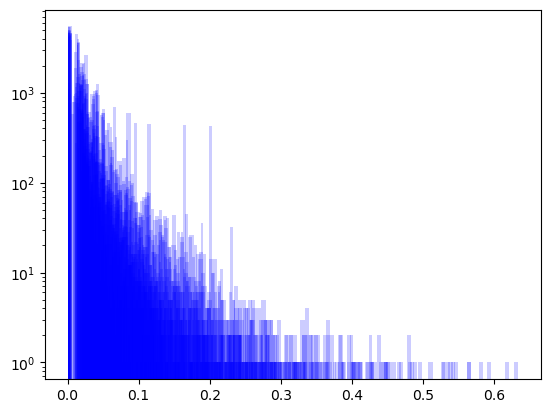

In [26]:
#sns.set_palette("bright")
for i in vst_dt.iloc[:,3:25].columns:
    plt.hist(vst_dt[i], bins=100, alpha=0.2, log=True, color="blue")

In [27]:
vst_dt[vst_dt.CHR== 'chr8'].sort_values(by=['WestEurasia-Oceania', 'START'],ascending=False).head(50)

#chr8	23424961	23435696

,CHR,START,END,WestEurasia-Oceania,WestEurasia-America,WestEurasia-Africa,WestEurasia-EastAsia,WestEurasia-SouthAsia,WestEurasia-CentralAsiaSiberia,Oceania-America,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
9157,chr8,23424961,23435696,0.34639,0.01370,0.09504,0.00932,0.01370,0.01370,0.29419,...,0.07859,0.02174,0.00000,0.00000,0.07698,0.10163,0.08916,0.02174,0.02174,0.00000
9505,chr8,144767201,144782295,0.32043,0.02486,0.01142,0.18178,0.02898,0.12367,0.21463,...,0.02226,0.07992,0.01735,0.06357,0.13755,0.02077,0.09951,0.08814,0.01988,0.05684
9365,chr8,88377645,88386330,0.11454,0.05417,0.02844,0.01128,0.01461,0.01113,0.24807,...,0.11332,0.06141,0.06272,0.07939,0.04913,0.05792,0.04226,0.01260,0.01398,0.01729
9140,chr8,19032169,19052143,0.10041,0.01349,0.00885,0.01676,0.01310,0.01062,0.07431,...,0.02088,0.01600,0.01727,0.02226,0.02085,0.01804,0.01603,0.01260,0.01722,0.01671
9273,chr8,56432862,56447376,0.09498,0.01170,0.03411,0.00844,0.01984,0.17676,0.11785,...,0.04412,0.01600,0.03317,0.18202,0.03845,0.01559,0.08259,0.02442,0.18735,0.11342
9314,chr8,68584437,68594990,0.09477,0.01076,0.02029,0.06451,0.00988,0.01346,0.15176,...,0.02726,0.07005,0.01800,0.02577,0.03048,0.01929,0.04523,0.05941,0.10815,0.02452
9499,chr8,142577933,142586954,0.07837,0.01998,0.01812,0.03695,0.01847,0.03864,0.17972,...,0.06621,0.08943,0.07249,0.02621,0.01967,0.01266,0.11478,0.02063,0.14452,0.12500
9130,chr8,16481751,16494016,0.07729,0.01337,0.00912,0.01676,0.01964,0.01273,0.06616,...,0.01789,0.01601,0.01906,0.03578,0.01673,0.02007,0.02056,0.01208,0.03308,0.03970
9111,chr8,8393710,8407139,0.07560,0.02125,0.02330,0.02149,0.01562,0.06737,0.05547,...,0.01640,0.01536,0.02098,0.04552,0.01165,0.01606,0.04366,0.01400,0.04708,0.06537
9196,chr8,39447636,39463249,0.07368,0.00000,0.00000,0.00000,0.04394,0.00000,0.06151,...,0.00000,0.00000,0.03571,0.00000,0.00000,0.04033,0.00000,0.04108,0.00000,0.03759


In [28]:
permutation_results = pd.read_csv("permutation_chm13_gene_regions.csv",index_col='Unnamed: 0')
permutation_results

,0,1,2,3,4,5,6,7,8,9,...,10738,10739,10740,10741,10742,10743,10744,10745,10746,10747
WestEurasia-Oceania,0.3793,0.0280,0.0001,0.8140,0.1202,0.0001,0.3759,0.2829,0.4171,0.0001,...,0.8182,0.5629,0.8153,0.7986,0.5914,0.4550,0.4182,1.0000,1.0000,0.6259
WestEurasia-America,0.1820,0.9143,0.0001,0.1497,0.9669,0.9753,0.4336,0.7236,0.7389,0.0001,...,0.3583,0.1203,0.1750,0.2595,0.1446,0.1745,0.0499,1.0000,1.0000,0.5739
WestEurasia-Africa,0.0008,0.1420,0.0001,0.0501,0.7816,0.9989,0.5902,0.4835,0.4373,0.0807,...,0.3553,0.5354,0.3764,0.4500,0.7651,0.7477,0.5067,0.9182,0.9238,0.5247
WestEurasia-EastAsia,0.0185,0.9992,0.2731,0.6084,0.2827,0.4773,0.8467,1.0000,0.8004,0.2665,...,0.2974,0.2754,0.2097,0.2474,0.0836,0.2065,0.2340,0.9256,0.9244,0.6225
WestEurasia-SouthAsia,0.0005,0.7566,0.0001,0.4826,0.1429,0.7589,0.1025,0.9730,0.0174,0.3476,...,0.0390,0.1056,0.0907,0.1008,0.1058,0.1433,0.0532,0.8419,0.8430,0.9694
WestEurasia-CentralAsiaSiberia,0.0582,0.2051,0.0001,0.2790,0.2265,0.7238,0.1521,0.6567,0.7623,0.0001,...,0.0169,0.0422,0.0061,0.0041,0.0141,0.0328,0.0419,0.0508,0.0547,0.5823
Oceania-America,0.6592,0.3324,0.0001,0.1472,0.2686,0.0024,0.2534,0.0947,0.0001,0.0001,...,0.5947,0.4555,0.3697,0.4722,0.4524,0.5211,0.2948,0.0001,0.0001,0.0001
Oceania-Africa,0.0007,0.5807,0.0001,0.2379,0.3356,0.0001,0.9861,0.5129,0.0001,0.5301,...,0.3986,0.3344,0.4028,0.4172,0.4446,0.3346,0.2260,0.0001,0.0001,0.0001
Oceania-EastAsia,0.3709,0.0689,0.8111,0.0001,0.5154,0.0003,0.3409,0.2565,0.0001,0.7966,...,0.5630,0.8614,0.4597,0.5532,0.4659,0.7511,0.8815,0.5750,0.5597,0.5715
Oceania-SouthAsia,0.0209,0.0710,0.0001,0.3888,0.0221,0.0008,0.7562,0.2881,0.4050,1.0000,...,0.0751,0.0506,0.1266,0.1278,0.0809,0.0626,0.0250,0.0001,1.0000,1.0000


In [29]:
boolean = (permutation_results<=0.05)


## Deleting columns where none of the regions passed the imputation
boolean = boolean.loc[:, boolean.any()]

In [30]:
boolean.columns = boolean.columns.astype(int)

In [31]:
# VST with permutation RESULTS 
pd.concat([filtering_vst.T, boolean.T],join='inner', axis=1)

,WestEurasia-Oceania,WestEurasia-America,WestEurasia-Africa,WestEurasia-EastAsia,WestEurasia-SouthAsia,WestEurasia-CentralAsiaSiberia,Oceania-America,Oceania-Africa,Oceania-EastAsia,Oceania-SouthAsia,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,True,True,False,False,False
5,True,False,False,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
30,False,False,False,False,False,False,False,False,False,False,...,True,True,False,False,False,False,True,False,True,True
35,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,True
52,False,False,False,False,False,False,True,False,False,False,...,False,True,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10736,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,True,False,True
10737,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,True,False,True
10738,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
10740,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,True,False,True


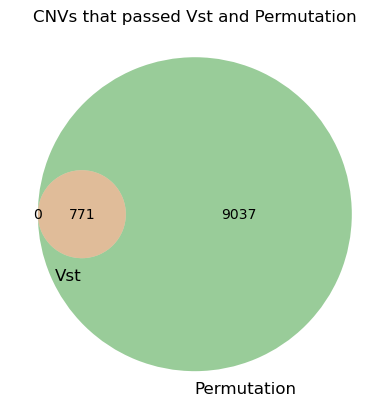

In [32]:
# VST with permutation RESULTS 
inner_vst = len(pd.concat([filtering_vst.T, boolean.T],join='inner', axis=1))
left_vst = len(filtering_vst.T) - inner_vst
right_vst = len(boolean.T) -inner_vst


venn2(subsets = (left_vst, right_vst, inner_vst), set_labels = ('Vst', 'Permutation'))
plt.title('CNVs that passed Vst and Permutation')
plt.show()

In [33]:
cnv_passed_vst = vst_dt.iloc[filtering_vst.columns]
cnv_passed_vst

,CHR,START,END,WestEurasia-Oceania,WestEurasia-America,WestEurasia-Africa,WestEurasia-EastAsia,WestEurasia-SouthAsia,WestEurasia-CentralAsiaSiberia,Oceania-America,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
0,chr1,102061,111943,0.01834,0.03053,0.10689,0.05349,0.13989,0.04516,0.02785,...,0.22796,0.01875,0.08211,0.02384,0.25003,0.38865,0.27465,0.04123,0.01440,0.06735
5,chr1,1116984,1126261,0.21183,0.01088,0.00891,0.01308,0.01160,0.01197,0.25844,...,0.01640,0.01921,0.01913,0.02360,0.01708,0.01531,0.01743,0.01206,0.01420,0.01544
30,chr1,9337554,9350106,0.02579,0.14029,0.00912,0.02263,0.03687,0.17267,0.08796,...,0.17695,0.08299,0.06437,0.02223,0.03014,0.04744,0.20013,0.01437,0.10290,0.07930
35,chr1,9852641,9861819,0.01044,0.01567,0.05117,0.00841,0.01500,0.13504,0.02827,...,0.08528,0.02112,0.04083,0.21588,0.05627,0.02953,0.04461,0.01869,0.15482,0.10585
52,chr1,12549468,12564684,0.01143,0.14668,0.09757,0.01238,0.02034,0.04428,0.28729,...,0.04949,0.09442,0.16881,0.08743,0.05031,0.12673,0.02490,0.03249,0.02484,0.07591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10736,chrY,24211645,24229764,0.01254,0.02530,0.01480,0.01700,0.03887,0.08079,0.03085,...,0.05317,0.01784,0.09779,0.03571,0.04023,0.02219,0.14081,0.08546,0.05250,0.23520
10737,chrY,24229764,24251349,0.01033,0.02374,0.01560,0.02033,0.03418,0.08528,0.03806,...,0.05531,0.01609,0.08758,0.04065,0.05004,0.01996,0.16229,0.08625,0.05038,0.22429
10738,chrY,24251349,24283859,0.01105,0.01903,0.01661,0.01791,0.04586,0.06881,0.02820,...,0.04302,0.01563,0.08019,0.03485,0.04630,0.02375,0.12686,0.10006,0.04442,0.21254
10740,chrY,25831552,25849672,0.01063,0.02972,0.01627,0.02176,0.03485,0.08566,0.04187,...,0.06571,0.01820,0.10471,0.03462,0.05435,0.01873,0.15970,0.09586,0.05306,0.23563


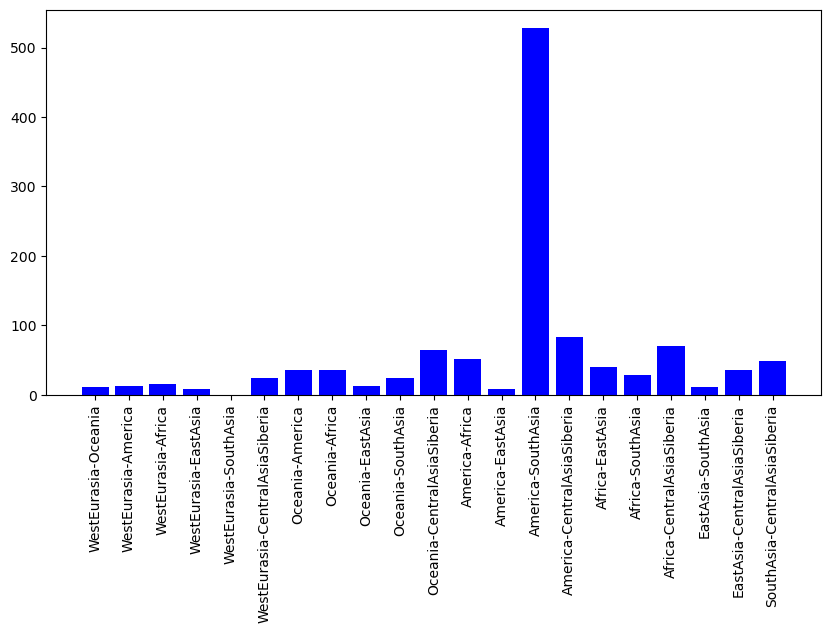

In [34]:
vst_fivehund = filtering_vst.T 
dist = vst_fivehund.sum()

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(dist.index, dist, color ='blue')
 
#plt.xlabel("Pairwise combination")
#plt.ylabel("# of CNVs passed perrmutation")
#plt.title("CNVs that passed Vst(pair-group) and permutation", size=20)
plt.xticks(rotation=90)
plt.savefig('../plots/distribution_864candidates_chm13.png', transparent=True)
plt.show()


<h1> Introducing cnvs from old assembly 

In [35]:
cnv_vst_hg19 = pd.read_csv("../data/candidates_572.csv", index_col='Unnamed: 0')
cnv_vst_hg19['start'] = cnv_vst_hg19['start'] +1
cnv_vst_hg19['start'] = cnv_vst_hg19['start'].apply(lambda x: str(x))
cnv_vst_hg19['end'] = cnv_vst_hg19['end'].apply(lambda x: str(x))
cnv_vst_hg19['chr'] = cnv_vst_hg19['chr'].apply(lambda x: "chr" + str(x))
#cnv_vst_hg19['start'] = pd.to_numeric(cnv_vst_hg19['start'])
#cnv_vst_hg19['end'] = pd.to_numeric(cnv_vst_hg19['end'])
cnv_vst_hg19

,chr,start,end,WestEurasia-SouthAsia,WestEurasia-Africa,WestEurasia-CentralAsiaSiberia,WestEurasia-Oceania,WestEurasia-America,WestEurasia-EastAsia,SouthAsia-Africa,...,Africa-Oceania,Africa-America,Africa-EastAsia,CentralAsiaSiberia-Oceania,CentralAsiaSiberia-America,CentralAsiaSiberia-EastAsia,Oceania-America,Oceania-EastAsia,America-EastAsia,i
36,chr1,8359740,8364181,0.00000,0.00000,0.24315,0.00000,0.39153,0.00000,0.00000,...,0.00000,0.36120,0.00000,0.18161,0.05147,0.22035,0.31300,0.00000,0.36420,36.0
37,chr1,9845437,9863387,0.07945,0.01864,0.02141,0.01143,0.26365,0.03671,0.11468,...,0.04167,0.32252,0.06674,0.02460,0.17789,0.01670,0.21695,0.02725,0.13876,37.0
49,chr1,13725297,13733660,0.02354,0.09123,0.17270,0.02803,0.02789,0.06315,0.04125,...,0.23619,0.23093,0.01584,0.35185,0.34632,0.09341,0.02175,0.17861,0.17451,49.0
51,chr1,14436061,14439381,0.00894,0.01929,0.00993,0.01104,0.02750,0.11985,0.02528,...,0.01977,0.07347,0.06890,0.02120,0.04302,0.12929,0.05971,0.10741,0.22469,51.0
55,chr1,16148565,16154830,0.00921,0.08575,0.14497,0.04836,0.03506,0.13211,0.10642,...,0.23843,0.02551,0.01736,0.40450,0.08633,0.01823,0.18424,0.31536,0.04744,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8586,chrX,146037798,146042345,0.00000,0.22866,0.00000,0.00000,0.00000,0.00000,0.18613,...,0.15109,0.14490,0.19776,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,8586.0
8588,chrX,146360193,146369374,0.01949,0.14968,0.01214,0.03007,0.18268,0.00881,0.08272,...,0.16964,0.01835,0.10098,0.05587,0.19868,0.01604,0.34919,0.01962,0.09108,8588.0
8646,chrX,154788812,154840186,0.00886,0.05787,0.01827,0.15949,0.01066,0.01285,0.06030,...,0.06213,0.06873,0.09885,0.30299,0.02814,0.01498,0.24022,0.25329,0.01709,8646.0
8647,chrX,154789311,154826421,0.00885,0.05665,0.01856,0.15703,0.01072,0.01312,0.06030,...,0.06213,0.06873,0.09885,0.30299,0.02814,0.01498,0.24022,0.25329,0.01709,8647.0


In [36]:
lifover_hg19_chm13 = pd.read_csv("../data/hglft_genome_33223_b1ed30.bed", sep='\t', names=['CHR','START','END','OLD','i']) 
#lifover_hg19_chm13['START'] = lifover_hg19_chm13['START'].apply(lambda x: str(x))
#lifover_hg19_chm13['END'] = lifover_hg19_chm13['END'].apply(lambda x: str(x))
lifover_hg19_chm13[['chr', 'position']] = lifover_hg19_chm13.OLD.str.split(":", expand = True)
lifover_hg19_chm13['chr_num'] = lifover_hg19_chm13['chr'].map(lambda x: x.lstrip('chr').rstrip('aAbBcC'))
lifover_hg19_chm13[['start', 'end']] = lifover_hg19_chm13.position.str.split("-", expand = True)
lifover_hg19_chm13

,CHR,START,END,OLD,i,chr,position,chr_num,start,end
0,chr1,7831416,7835810,chr1:8359740-8364181,1,chr1,8359740-8364181,1,8359740,8364181
1,chr1,9328164,9346113,chr1:9845437-9863387,1,chr1,9845437-9863387,1,9845437,9863387
2,chr1,12840112,12848473,chr1:13725297-13733660,1,chr1,13725297-13733660,1,13725297,13733660
3,chr1,13551736,13555057,chr1:14436061-14439381,1,chr1,14436061-14439381,1,14436061,14439381
4,chr1,15266831,15270191,chr1:16148565-16154830,1,chr1,16148565-16154830,1,16148565,16154830
...,...,...,...,...,...,...,...,...,...,...
695,chrX,153797464,153835748,chrX:154788812-154840186,1,chrX,154788812-154840186,X,154788812,154840186
696,chrX,153847068,153847378,chrX:154788812-154840186,2,chrX,154788812-154840186,X,154788812,154840186
697,chrX,153797963,153821992,chrX:154789311-154826421,1,chrX,154789311-154826421,X,154789311,154826421
698,chrX,153847068,153847378,chrX:154789311-154826421,2,chrX,154789311-154826421,X,154789311,154826421


In [37]:
#cnv_vst_hg19.merge(lifover_hg19_chm13, how='inner', on=['chr,start,end'])
#cnv_passed_vst

cnvs_hg19_overlift = pd.merge(cnv_vst_hg19, lifover_hg19_chm13,  how='inner', left_on=['chr','start','end'], right_on = ['chr','start','end'])
cnvs_hg19_overlift

,chr,start,end,WestEurasia-SouthAsia,WestEurasia-Africa,WestEurasia-CentralAsiaSiberia,WestEurasia-Oceania,WestEurasia-America,WestEurasia-EastAsia,SouthAsia-Africa,...,Oceania-EastAsia,America-EastAsia,i_x,CHR,START,END,OLD,i_y,position,chr_num
0,chr1,8359740,8364181,0.00000,0.00000,0.24315,0.00000,0.39153,0.00000,0.00000,...,0.00000,0.36420,36.0,chr1,7831416,7835810,chr1:8359740-8364181,1,8359740-8364181,1
1,chr1,9845437,9863387,0.07945,0.01864,0.02141,0.01143,0.26365,0.03671,0.11468,...,0.02725,0.13876,37.0,chr1,9328164,9346113,chr1:9845437-9863387,1,9845437-9863387,1
2,chr1,13725297,13733660,0.02354,0.09123,0.17270,0.02803,0.02789,0.06315,0.04125,...,0.17861,0.17451,49.0,chr1,12840112,12848473,chr1:13725297-13733660,1,13725297-13733660,1
3,chr1,14436061,14439381,0.00894,0.01929,0.00993,0.01104,0.02750,0.11985,0.02528,...,0.10741,0.22469,51.0,chr1,13551736,13555057,chr1:14436061-14439381,1,14436061-14439381,1
4,chr1,16148565,16154830,0.00921,0.08575,0.14497,0.04836,0.03506,0.13211,0.10642,...,0.31536,0.04744,55.0,chr1,15266831,15270191,chr1:16148565-16154830,1,16148565-16154830,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,chrX,154788812,154840186,0.00886,0.05787,0.01827,0.15949,0.01066,0.01285,0.06030,...,0.25329,0.01709,8646.0,chrX,153797464,153835748,chrX:154788812-154840186,1,154788812-154840186,X
694,chrX,154788812,154840186,0.00886,0.05787,0.01827,0.15949,0.01066,0.01285,0.06030,...,0.25329,0.01709,8646.0,chrX,153847068,153847378,chrX:154788812-154840186,2,154788812-154840186,X
695,chrX,154789311,154826421,0.00885,0.05665,0.01856,0.15703,0.01072,0.01312,0.06030,...,0.25329,0.01709,8647.0,chrX,153797963,153821992,chrX:154789311-154826421,1,154789311-154826421,X
696,chrX,154789311,154826421,0.00885,0.05665,0.01856,0.15703,0.01072,0.01312,0.06030,...,0.25329,0.01709,8647.0,chrX,153847068,153847378,chrX:154789311-154826421,2,154789311-154826421,X


<h1> gene anotation for chm13

In [38]:
feature_table = pd.read_table('../data/GCF_009914755.1_T2T-CHM13v2.0_feature_table.txt')#, index_col='chromosome')
report = pd.read_table('../data/GCF_009914755.1_T2T-CHM13v2.0_assembly_report.txt')

chm13_gene_anotation = feature_table.merge(report, left_on='genomic_accession', right_on='RefSeq-Accn')
chm13_gene_anotation[chm13_gene_anotation['class'] == 'protein_coding']
gene_anotation = pd.DataFrame()
gene_anotation['CHR_2'] = chm13_gene_anotation['GenBank-Accn']
gene_anotation['START'] = chm13_gene_anotation['start']
gene_anotation['END'] = chm13_gene_anotation['end']
gene_anotation['CHR'] = chm13_gene_anotation['chromosome'] 
gene_anotation['SYMBOL'] = chm13_gene_anotation['symbol'] 
gene_anotation['GENEID'] = chm13_gene_anotation['GeneID'] 
gene_anotation['CHR'] = gene_anotation['CHR'].apply(lambda x: "chr" + str(x))
gene_anotation = gene_anotation.drop_duplicates()
gene_anotation[gene_anotation['SYMBOL'] == 'METTL9']

/var/folders/05/4pfxtbrs5459ytz3j1jhcgt00000gn/T/ipykernel_55626/1145189376.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  feature_table = pd.read_table('../data/GCF_009914755.1_T2T-CHM13v2.0_feature_table.txt')#, index_col='chromosome')


,CHR_2,START,END,CHR,SYMBOL,GENEID
174108,CP068262.2,22559463,22619737,chr16,METTL9,51108
174111,CP068262.2,22559463,22617368,chr16,METTL9,51108
174113,CP068262.2,22561502,22619689,chr16,METTL9,51108
174115,CP068262.2,22561502,22617211,chr16,METTL9,51108


In [39]:
overlapped = []

cnvs_hg19_overlift_np = gene_anotation.to_numpy()
cnv_passed_vst_np = cnv_passed_vst.to_numpy()

for cnv_q in cnvs_hg19_overlift_np:
    for cnv_c in cnv_passed_vst_np:
    
        if cnv_q[3] == cnv_c[0]: #Chromosome
            # QDNASEQ CNVS in SUDMANT DATA(SUDMANT bigger than  QDNASEQ)
            if (cnv_c[1] <= cnv_q[1] <= cnv_c[2]) or (cnv_c[1] <= cnv_q[2] <= cnv_c[2]):
                #leng_dqna = (cnv_q[3]-cnv_q[2])
                #leng_cnvnator = (cnv_c[2]-cnv_c[1])
                #if (leng_dqna/leng_cnvnator)>0.6:
                overlapped.append([cnv_c[0], cnv_c[1], cnv_c[2], cnv_q[4]])
                    #overlapped.append(cnv_q)
            # SUDMANT DATA CNVS in QDNASEQ CNVs(QDNASEQ bigger than SUDMANT DATA)
            
            if (cnv_q[1] <= cnv_c[1] <= cnv_q[2]) or (cnv_q[1] <= cnv_c[2] <= cnv_q[2]):
                #leng_dq/na = (cnv_q[3]-cnv_q[2])
                #leng_cnvnator = (cnv_c[2]-cnv_c[1])
                #if (leng_cnvnator/leng_dqna)>0.6:
                overlapped.append([cnv_c[0], cnv_c[1], cnv_c[2], cnv_q[4]])
                    #overlapped.append([cnv_q, cnv_c])
                    #overlapped.append(cnv_q)

In [40]:
genes = pd.DataFrame(overlapped).drop_duplicates()
genes.columns = ['CHR', 'START', 'END', 'SYMBOL']
genes#.sort_values(by='SYMBOL')

,CHR,START,END,SYMBOL
0,chr1,102061,111943,OR4F29
2,chr1,1116984,1126261,SLC35E2B
3,chr1,9337554,9350106,CLSTN1
7,chr1,9852641,9861819,KIF1B
11,chr1,12549468,12564684,PRAMEF13
...,...,...,...,...
2601,chrY,24211645,24229764,BPY2B
2603,chrY,24229764,24251349,BPY2B
2606,chrY,24251349,24283859,TTTY4B
2608,chrY,25831552,25849672,BPY2


In [41]:
genes[genes['SYMBOL'] == 'METTL9']

,CHR,START,END,SYMBOL


In [44]:
cnv_passed_vst = genes.merge(cnv_passed_vst)
cnv_passed_vst.to_csv('../data/vst_864_t2t_candidates_gene_anotation.csv')
cnv_passed_vst
#864

,CHR,START,END,SYMBOL,WestEurasia-Oceania,WestEurasia-America,WestEurasia-Africa,WestEurasia-EastAsia,WestEurasia-SouthAsia,WestEurasia-CentralAsiaSiberia,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
0,chr1,102061,111943,OR4F29,0.01834,0.03053,0.10689,0.05349,0.13989,0.04516,...,0.22796,0.01875,0.08211,0.02384,0.25003,0.38865,0.27465,0.04123,0.01440,0.06735
1,chr1,1116984,1126261,SLC35E2B,0.21183,0.01088,0.00891,0.01308,0.01160,0.01197,...,0.01640,0.01921,0.01913,0.02360,0.01708,0.01531,0.01743,0.01206,0.01420,0.01544
2,chr1,9337554,9350106,CLSTN1,0.02579,0.14029,0.00912,0.02263,0.03687,0.17267,...,0.17695,0.08299,0.06437,0.02223,0.03014,0.04744,0.20013,0.01437,0.10290,0.07930
3,chr1,9852641,9861819,KIF1B,0.01044,0.01567,0.05117,0.00841,0.01500,0.13504,...,0.08528,0.02112,0.04083,0.21588,0.05627,0.02953,0.04461,0.01869,0.15482,0.10585
4,chr1,12549468,12564684,PRAMEF13,0.01143,0.14668,0.09757,0.01238,0.02034,0.04428,...,0.04949,0.09442,0.16881,0.08743,0.05031,0.12673,0.02490,0.03249,0.02484,0.07591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,chrY,24211645,24229764,BPY2B,0.01254,0.02530,0.01480,0.01700,0.03887,0.08079,...,0.05317,0.01784,0.09779,0.03571,0.04023,0.02219,0.14081,0.08546,0.05250,0.23520
860,chrY,24229764,24251349,BPY2B,0.01033,0.02374,0.01560,0.02033,0.03418,0.08528,...,0.05531,0.01609,0.08758,0.04065,0.05004,0.01996,0.16229,0.08625,0.05038,0.22429
861,chrY,24251349,24283859,TTTY4B,0.01105,0.01903,0.01661,0.01791,0.04586,0.06881,...,0.04302,0.01563,0.08019,0.03485,0.04630,0.02375,0.12686,0.10006,0.04442,0.21254
862,chrY,25831552,25849672,BPY2,0.01063,0.02972,0.01627,0.02176,0.03485,0.08566,...,0.06571,0.01820,0.10471,0.03462,0.05435,0.01873,0.15970,0.09586,0.05306,0.23563


In [31]:
cnvs_hg19_overlift

,chr,start,end,WestEurasia-SouthAsia,WestEurasia-Africa,WestEurasia-CentralAsiaSiberia,WestEurasia-Oceania,WestEurasia-America,WestEurasia-EastAsia,SouthAsia-Africa,...,Oceania-EastAsia,America-EastAsia,i_x,CHR,START,END,OLD,i_y,position,chr_num
0,chr1,8359740,8364181,0.00000,0.00000,0.24315,0.00000,0.39153,0.00000,0.00000,...,0.00000,0.36420,36.0,chr1,7831416,7835810,chr1:8359740-8364181,1,8359740-8364181,1
1,chr1,9845437,9863387,0.07945,0.01864,0.02141,0.01143,0.26365,0.03671,0.11468,...,0.02725,0.13876,37.0,chr1,9328164,9346113,chr1:9845437-9863387,1,9845437-9863387,1
2,chr1,13725297,13733660,0.02354,0.09123,0.17270,0.02803,0.02789,0.06315,0.04125,...,0.17861,0.17451,49.0,chr1,12840112,12848473,chr1:13725297-13733660,1,13725297-13733660,1
3,chr1,14436061,14439381,0.00894,0.01929,0.00993,0.01104,0.02750,0.11985,0.02528,...,0.10741,0.22469,51.0,chr1,13551736,13555057,chr1:14436061-14439381,1,14436061-14439381,1
4,chr1,16148565,16154830,0.00921,0.08575,0.14497,0.04836,0.03506,0.13211,0.10642,...,0.31536,0.04744,55.0,chr1,15266831,15270191,chr1:16148565-16154830,1,16148565-16154830,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,chrX,154788812,154840186,0.00886,0.05787,0.01827,0.15949,0.01066,0.01285,0.06030,...,0.25329,0.01709,8646.0,chrX,153797464,153835748,chrX:154788812-154840186,1,154788812-154840186,X
694,chrX,154788812,154840186,0.00886,0.05787,0.01827,0.15949,0.01066,0.01285,0.06030,...,0.25329,0.01709,8646.0,chrX,153847068,153847378,chrX:154788812-154840186,2,154788812-154840186,X
695,chrX,154789311,154826421,0.00885,0.05665,0.01856,0.15703,0.01072,0.01312,0.06030,...,0.25329,0.01709,8647.0,chrX,153797963,153821992,chrX:154789311-154826421,1,154789311-154826421,X
696,chrX,154789311,154826421,0.00885,0.05665,0.01856,0.15703,0.01072,0.01312,0.06030,...,0.25329,0.01709,8647.0,chrX,153847068,153847378,chrX:154789311-154826421,2,154789311-154826421,X


<h1> overlapped with hg19

In [32]:
overlapped = []

cnvs_hg19_overlift_np = cnvs_hg19_overlift.to_numpy()
cnv_passed_vst_np = cnv_passed_vst.to_numpy()

for cnv_q in cnvs_hg19_overlift_np:
    for cnv_c in cnv_passed_vst_np:
    
        if cnv_q[-7] == cnv_c[0]: #Chromosome
            # 
            if (cnv_c[1] <= cnv_q[-6] <= cnv_c[2]) or (cnv_c[1] <= cnv_q[-5] <= cnv_c[2]):
                #leng_dqna = (cnv_q[3]-cnv_q[2])
                #leng_cnvnator = (cnv_c[2]-cnv_c[1])
                #if (leng_dqna/leng_cnvnator)>0.6:
                overlapped.append([cnv_q[-7], cnv_q[-6], cnv_q[-5], cnv_c[0], cnv_c[1], cnv_c[2],cnv_q[0], cnv_q[1], cnv_q[2]])
                    #overlapped.append(cnv_q)
            # 
            
            if (cnv_q[-6] <= cnv_c[1] <= cnv_q[-5]) or (cnv_q[-6] <= cnv_c[2] <= cnv_q[-5]):
                #leng_dq/na = (cnv_q[3]-cnv_q[2])
                #leng_cnvnator = (cnv_c[2]-cnv_c[1])
                #if (leng_cnvnator/leng_dqna)>0.6:
                overlapped.append([cnv_q[-7], cnv_q[-6], cnv_q[-5], cnv_c[0], cnv_c[1], cnv_c[2], cnv_q[0], cnv_q[1], cnv_q[2]])
                    #overlapped.append([cnv_q, cnv_c])
                    #overlapped.append(cnv_q)

In [33]:
overlapped_cnvs = pd.DataFrame(overlapped)
overlapped_cnvs = overlapped_cnvs.drop_duplicates()
overlapped_cnvs

,0,1,2,3,4,5,6,7,8
0,chr1,9328164,9346113,chr1,9337554,9350106,chr1,9845437,9863387
2,chr1,144416713,144500870,chr1,144416000,144502839,chr1,146374570,146466519
3,chr1,147813464,147869168,chr1,147813843,147824531,chr1,146374570,146466519
4,chr1,144467509,144468142,chr1,144416000,144502839,chr1,146374570,146466519
5,chr1,168602793,168640912,chr1,168602705,168615424,chr1,169216545,169254678
7,chr1,168602793,168640912,chr1,168616996,168625289,chr1,169216545,169254678
8,chr11,47189450,47199853,chr11,47189271,47198341,chr11,47054131,47064534
12,chr11,47189450,47199853,chr11,47198341,47207572,chr11,47054131,47064534
16,chr12,8170591,8419854,chr12,8170744,8180936,chr12,8309584,8561113
17,chr14,67731462,67794751,chr14,67767430,67776722,chr14,73990658,74053945


In [34]:
overlapped_cnvs.columns = ['chr', 'start', 'end', 'CHR','START', 'END', 'chr_19', 'start_19', 'end_19']
overlapped_cnvs['lenght'] = overlapped_cnvs['end'] - overlapped_cnvs['start']
overlapped_cnvs['LENGHT'] = overlapped_cnvs['END'] - overlapped_cnvs['START']
overlapped_cnvs

,chr,start,end,CHR,START,END,chr_19,start_19,end_19,lenght,LENGHT
0,chr1,9328164,9346113,chr1,9337554,9350106,chr1,9845437,9863387,17949,12552
2,chr1,144416713,144500870,chr1,144416000,144502839,chr1,146374570,146466519,84157,86839
3,chr1,147813464,147869168,chr1,147813843,147824531,chr1,146374570,146466519,55704,10688
4,chr1,144467509,144468142,chr1,144416000,144502839,chr1,146374570,146466519,633,86839
5,chr1,168602793,168640912,chr1,168602705,168615424,chr1,169216545,169254678,38119,12719
7,chr1,168602793,168640912,chr1,168616996,168625289,chr1,169216545,169254678,38119,8293
8,chr11,47189450,47199853,chr11,47189271,47198341,chr11,47054131,47064534,10403,9070
12,chr11,47189450,47199853,chr11,47198341,47207572,chr11,47054131,47064534,10403,9231
16,chr12,8170591,8419854,chr12,8170744,8180936,chr12,8309584,8561113,249263,10192
17,chr14,67731462,67794751,chr14,67767430,67776722,chr14,73990658,74053945,63289,9292


In [35]:
cnvs_chm13and_hg19 = overlapped_cnvs.merge(cnv_passed_vst, how='inner', on=['CHR', 'START','END'])
cnvs_chm13and_hg19#.to_csv('31candidatesfromhg19andchm13.csv')

,chr,start,end,CHR,START,END,chr_19,start_19,end_19,lenght,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
0,chr1,9328164,9346113,chr1,9337554,9350106,chr1,9845437,9863387,17949,...,0.17695,0.08299,0.06438,0.02223,0.03014,0.04744,0.20013,0.01437,0.10290,0.07930
1,chr1,144416713,144500870,chr1,144416000,144502839,chr1,146374570,146466519,84157,...,0.06280,0.09454,0.04120,0.13886,0.22446,0.15324,0.26005,0.06072,0.01760,0.06293
2,chr1,144467509,144468142,chr1,144416000,144502839,chr1,146374570,146466519,633,...,0.06280,0.09454,0.04120,0.13886,0.22446,0.15324,0.26005,0.06072,0.01760,0.06293
3,chr1,147813464,147869168,chr1,147813843,147824531,chr1,146374570,146466519,55704,...,0.05934,0.08749,0.04344,0.13980,0.20843,0.15402,0.26197,0.05367,0.01651,0.06119
4,chr1,168602793,168640912,chr1,168602705,168615424,chr1,169216545,169254678,38119,...,0.10981,0.10079,0.23171,0.14815,0.01758,0.02728,0.01767,0.05967,0.01420,0.05171
5,chr1,168602793,168640912,chr1,168616996,168625289,chr1,169216545,169254678,38119,...,0.10823,0.10079,0.21770,0.13556,0.02092,0.02525,0.01614,0.06580,0.01711,0.04034
6,chr11,47189450,47199853,chr11,47189271,47198341,chr11,47054131,47064534,10403,...,0.29567,0.02154,0.01971,0.13040,0.18997,0.31585,0.62081,0.03103,0.16441,0.08879
7,chr11,47189450,47199853,chr11,47189271,47198341,chr11,47054131,47064534,10403,...,0.29567,0.02154,0.01971,0.13040,0.18997,0.31585,0.62081,0.03103,0.16441,0.08879
8,chr11,47189450,47199853,chr11,47198341,47207572,chr11,47054131,47064534,10403,...,0.17276,0.01550,0.04498,0.11764,0.15998,0.29239,0.44848,0.03631,0.09500,0.03478
9,chr11,47189450,47199853,chr11,47198341,47207572,chr11,47054131,47064534,10403,...,0.17276,0.01550,0.04498,0.11764,0.15998,0.29239,0.44848,0.03631,0.09500,0.03478


In [36]:
cnvs_chm13and_hg19 = cnvs_chm13and_hg19.drop_duplicates(subset=['SYMBOL'])#.sort_values(by='WestEurasia-Oceania', ascending=False)
cnvs_chm13and_hg19 = cnvs_chm13and_hg19.drop_duplicates(subset=['START'])
cnvs_chm13and_hg19 = cnvs_chm13and_hg19.drop_duplicates(subset=['start'])
cnvs_chm13and_hg19['start_19'] = cnvs_chm13and_hg19['start_19'].astype(int)
cnvs_chm13and_hg19['end_19'] = cnvs_chm13and_hg19['end_19'].astype(int)
cnvs_chm13and_hg19

,chr,start,end,CHR,START,END,chr_19,start_19,end_19,lenght,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
0,chr1,9328164,9346113,chr1,9337554,9350106,chr1,9845437,9863387,17949,...,0.17695,0.08299,0.06438,0.02223,0.03014,0.04744,0.20013,0.01437,0.10290,0.07930
1,chr1,144416713,144500870,chr1,144416000,144502839,chr1,146374570,146466519,84157,...,0.06280,0.09454,0.04120,0.13886,0.22446,0.15324,0.26005,0.06072,0.01760,0.06293
3,chr1,147813464,147869168,chr1,147813843,147824531,chr1,146374570,146466519,55704,...,0.05934,0.08749,0.04344,0.13980,0.20843,0.15402,0.26197,0.05367,0.01651,0.06119
4,chr1,168602793,168640912,chr1,168602705,168615424,chr1,169216545,169254678,38119,...,0.10981,0.10079,0.23171,0.14815,0.01758,0.02728,0.01767,0.05967,0.01420,0.05171
6,chr11,47189450,47199853,chr11,47189271,47198341,chr11,47054131,47064534,10403,...,0.29567,0.02154,0.01971,0.13040,0.18997,0.31585,0.62081,0.03103,0.16441,0.08879
10,chr12,8170591,8419854,chr12,8170744,8180936,chr12,8309584,8561113,249263,...,0.09062,0.05720,0.02009,0.19061,0.20170,0.11618,0.27440,0.03055,0.05792,0.10843
11,chr14,67731462,67794751,chr14,67767430,67776722,chr14,73990658,74053945,63289,...,0.01662,0.15325,0.01862,0.29078,0.17409,0.01578,0.28041,0.16775,0.05648,0.30533
12,chr15,18585440,18895389,chr15,18738899,18752260,chr15,21885407,22211793,309949,...,0.17120,0.17198,0.22800,0.16891,0.01713,0.01902,0.02424,0.01191,0.03883,0.04713
14,chr18,11772428,11801793,chr18,11772667,11782403,chr18,11610108,11639390,29365,...,0.43945,0.01903,0.19796,0.04907,0.13912,0.17621,0.35708,0.03496,0.01370,0.10298
16,chr2,179676720,179701753,chr2,179688499,179701803,chr2,180058235,180083270,25033,...,0.30680,0.08276,0.31081,0.19298,0.15287,0.01273,0.06377,0.14777,0.03715,0.06165


In [37]:
cnvs_hg19 = overlapped_cnvs.merge(cnvs_hg19_overlift,   how='inner', left_on=['chr','start','end'], right_on = ['CHR','START','END'])
cnvs_hg19 = cnvs_hg19.drop(columns=['chr_y','start_y', 'end_y'])
cnvs_hg19 = cnvs_hg19.drop(columns=['i_x','CHR_y','START_y','END_y','OLD','i_y','position','chr_num'])
cnvs_hg19 = cnvs_hg19.drop_duplicates(subset=['start_x'])
cnvs_hg19 = cnvs_hg19.drop_duplicates(subset=['START_x'])
cnvs_hg19.iloc[:,8:]

,end_19,lenght,LENGHT,WestEurasia-SouthAsia,WestEurasia-Africa,WestEurasia-CentralAsiaSiberia,WestEurasia-Oceania,WestEurasia-America,WestEurasia-EastAsia,SouthAsia-Africa,...,Africa-CentralAsiaSiberia,Africa-Oceania,Africa-America,Africa-EastAsia,CentralAsiaSiberia-Oceania,CentralAsiaSiberia-America,CentralAsiaSiberia-EastAsia,Oceania-America,Oceania-EastAsia,America-EastAsia
0,9863387,17949,12552,0.07945,0.01864,0.02141,0.01143,0.26365,0.03671,0.11468,...,0.06062,0.04167,0.32252,0.06674,0.02460,0.17789,0.01670,0.21695,0.02725,0.13876
1,146466519,84157,86839,0.00964,0.02151,0.01697,0.01526,0.10540,0.01062,0.01957,...,0.01478,0.01547,0.17361,0.03679,0.01963,0.21730,0.03289,0.16440,0.02806,0.11308
2,146466519,55704,10688,0.00964,0.02151,0.01697,0.01526,0.10540,0.01062,0.01957,...,0.01478,0.01547,0.17361,0.03679,0.01963,0.21730,0.03289,0.16440,0.02806,0.11308
4,169254678,38119,12719,0.02341,0.07891,0.07725,0.23212,0.20789,0.10017,0.03543,...,0.01450,0.11593,0.09762,0.01243,0.13607,0.11456,0.01390,0.02999,0.10482,0.08661
6,47064534,10403,9070,0.00925,0.35175,0.03601,0.02655,0.01584,0.02956,0.46648,...,0.67978,0.56647,0.39102,0.28616,0.02038,0.10574,0.12069,0.07684,0.09105,0.01832
8,8561113,249263,10192,0.02396,0.12854,0.01648,0.01290,0.05482,0.02687,0.19993,...,0.16124,0.07990,0.22769,0.20305,0.03883,0.05505,0.01634,0.09812,0.04565,0.02762
9,74053945,63289,9292,0.01208,0.01150,0.11138,0.14177,0.01418,0.16137,0.01206,...,0.18121,0.14113,0.01544,0.25322,0.45497,0.19659,0.01371,0.13050,0.55771,0.26396
10,22211793,309949,13361,0.02415,0.03061,0.01781,0.01223,0.05561,0.11284,0.01270,...,0.01699,0.05426,0.16725,0.04609,0.04397,0.16430,0.07326,0.07490,0.16634,0.35793
11,11639390,29365,9736,0.01078,0.11660,0.01044,0.19485,0.05182,0.00834,0.15247,...,0.13360,0.04054,0.26863,0.12003,0.27494,0.07369,0.01444,0.47218,0.22362,0.06730
12,180083270,25033,13304,0.00903,0.01688,0.05695,0.13099,0.23202,0.14813,0.01832,...,0.12237,0.23847,0.38939,0.24151,0.05653,0.19998,0.03860,0.10713,0.01548,0.08658


In [38]:
df1 = cnvs_chm13and_hg19.iloc[:,11:]
df2= cnvs_hg19.iloc[:,11:]


In [39]:
#cnv_passed_vst[cnv_passed_vst.SYMBOL =='TBC1D3']
d = pd.concat([df1, df2], axis=1, keys=['df1', 'df2']).corr(method='kendall').loc['df2', 'df1']
d

/var/folders/05/4pfxtbrs5459ytz3j1jhcgt00000gn/T/ipykernel_45599/1231915365.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  d = pd.concat([df1, df2], axis=1, keys=['df1', 'df2']).corr(method='kendall').loc['df2', 'df1']


,WestEurasia-Oceania,WestEurasia-America,WestEurasia-Africa,WestEurasia-EastAsia,WestEurasia-SouthAsia,WestEurasia-CentralAsiaSiberia,Oceania-America,Oceania-Africa,Oceania-EastAsia,Oceania-SouthAsia,...,America-Africa,America-EastAsia,America-SouthAsia,America-CentralAsiaSiberia,Africa-EastAsia,Africa-SouthAsia,Africa-CentralAsiaSiberia,EastAsia-SouthAsia,EastAsia-CentralAsiaSiberia,SouthAsia-CentralAsiaSiberia
WestEurasia-SouthAsia,0.054945,0.384615,-0.076923,0.296703,0.186813,0.362637,-0.054945,-0.230769,-0.120879,-0.142857,...,0.142857,-0.186813,0.208791,-0.110499,0.142857,-0.010989,0.098901,0.120879,0.054945,0.230769
WestEurasia-Africa,0.022100,-0.309397,0.375696,0.022100,-0.176798,0.088399,0.132599,0.132599,0.176798,0.044200,...,-0.066299,-0.088399,-0.309397,-0.033333,0.220998,0.287297,0.353597,0.154698,-0.220998,0.265197
WestEurasia-CentralAsiaSiberia,-0.054945,0.406593,-0.362637,0.230769,-0.054945,-0.098901,0.010989,0.274725,-0.186813,0.186813,...,0.340659,-0.032967,0.406593,0.132599,-0.362637,-0.472527,-0.450549,0.098901,0.120879,-0.098901
WestEurasia-Oceania,0.054945,0.032967,-0.032967,0.252747,-0.032967,0.010989,-0.142857,0.032967,0.406593,0.076923,...,0.054945,-0.186813,0.164835,-0.110499,0.098901,-0.010989,-0.076923,0.208791,-0.032967,-0.076923
WestEurasia-America,0.010989,0.340659,-0.296703,0.032967,0.318681,0.230769,0.032967,-0.142857,-0.428571,-0.054945,...,-0.076923,0.560440,0.252747,0.198898,-0.340659,-0.142857,-0.252747,-0.318681,-0.032967,-0.164835
WestEurasia-EastAsia,-0.164835,0.384615,-0.296703,0.120879,-0.076923,0.054945,-0.054945,0.164835,-0.208791,-0.054945,...,0.362637,-0.054945,0.472527,0.154698,-0.252747,-0.274725,-0.340659,-0.054945,0.230769,-0.164835
SouthAsia-Africa,-0.032967,-0.186813,0.186813,0.032967,-0.120879,0.186813,0.252747,0.120879,-0.032967,0.032967,...,0.142857,-0.098901,-0.230769,-0.176798,0.098901,0.164835,0.362637,0.032967,-0.076923,0.230769
SouthAsia-CentralAsiaSiberia,0.054945,0.340659,-0.340659,0.296703,-0.032967,-0.120879,0.384615,0.164835,-0.208791,0.120879,...,0.362637,-0.098901,0.384615,-0.176798,-0.076923,-0.230769,-0.252747,0.208791,-0.032967,0.010989
SouthAsia-Oceania,-0.076923,0.076923,-0.208791,0.120879,-0.164835,0.186813,-0.142857,-0.098901,0.274725,0.076923,...,0.054945,-0.186813,0.076923,-0.022100,-0.120879,-0.274725,-0.076923,0.164835,0.054945,0.142857
SouthAsia-America,0.076923,0.186813,-0.186813,0.010989,0.164835,-0.010989,0.098901,-0.032967,-0.318681,0.054945,...,-0.274725,0.538462,0.142857,0.287297,-0.186813,-0.164835,-0.274725,-0.252747,-0.274725,-0.142857


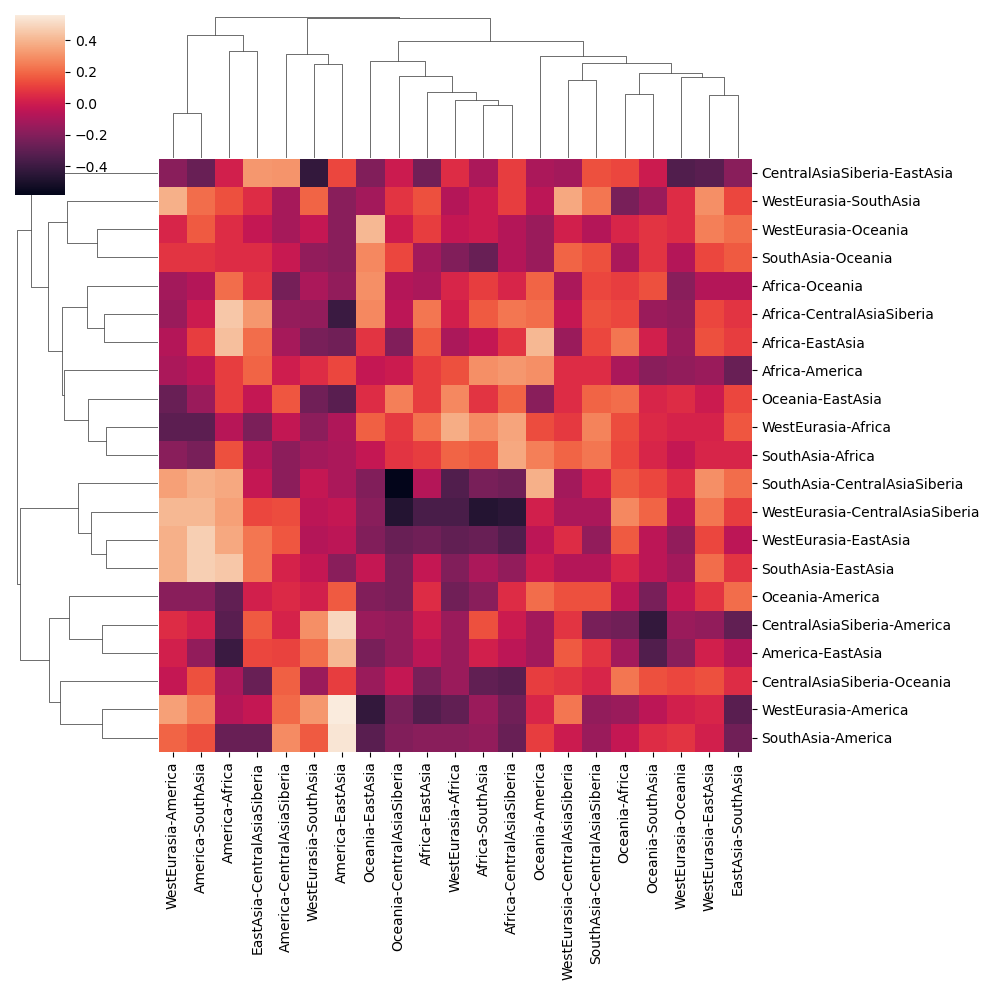

In [40]:
import seaborn as sns
sns.clustermap(d)

<Axes: >

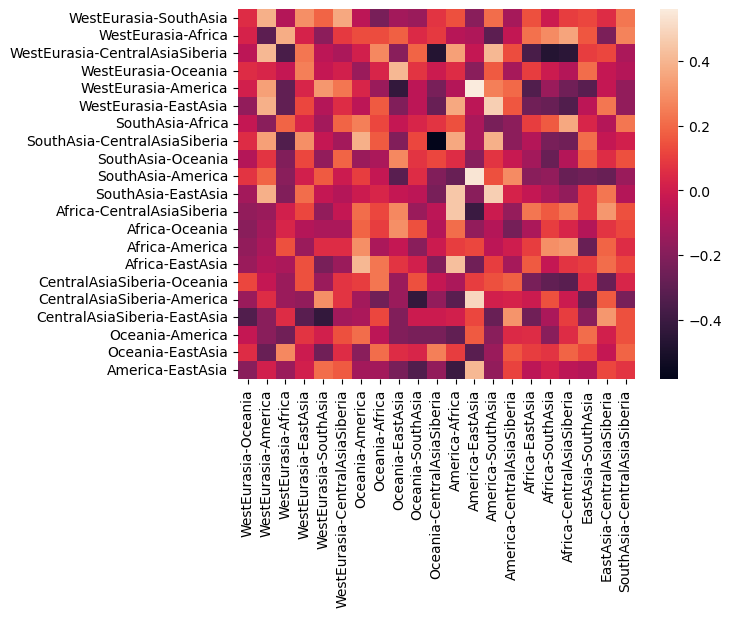

In [41]:
sns.heatmap(d)

In [42]:
new_samples = cnvs_chm13and_hg19.merge(cnv)
new_samples = new_samples.iloc[:,33:303]
new_samples = new_samples.fillna(2)

In [43]:
data19 = pd.read_csv("../data/cnvator_data_sudmant_overlapped.csv")
cnv19 = data19.pivot_table(index=["Chr", "Start", "End"], 
                    columns='Sample_ID', 
                    values='RD').reset_index()
cnv19['Start'] = cnv19['Start'].astype(int)
cnv19['Start'] = cnv19['Start'] +1
cnv19['End'] = cnv19['End'].astype(int)

In [44]:
from scipy.stats import zscore


old_samples = cnvs_chm13and_hg19.merge(cnv19, left_on=['start_19','end_19'], right_on = ['Start','End'])
old_samples = old_samples.iloc[:,36:313]
old_samples = old_samples.fillna(2)

In [45]:
samples_shared = np.intersect1d(old_samples.columns, new_samples.columns)

In [46]:
old_samples = old_samples[old_samples.columns.intersection(samples_shared)]
new_samples = new_samples[new_samples.columns.intersection(samples_shared)]
old_samples = old_samples.apply(zscore)
new_samples = new_samples.apply(zscore)

In [47]:
new_samples

,LP6005441-DNA_A01,LP6005441-DNA_A03,LP6005441-DNA_A04,LP6005441-DNA_A05,LP6005441-DNA_A06,LP6005441-DNA_A08,LP6005441-DNA_A09,LP6005441-DNA_A10,LP6005441-DNA_A11,LP6005441-DNA_A12,...,LP6005677-DNA_D03,LP6005677-DNA_E01,LP6005677-DNA_F01,LP6005677-DNA_G01,LP6007068-DNA_A01,LP6007069-DNA_A01,SS6004471,SS6004477,SS6004478,SS6004480
0,-0.438566,-0.455544,-0.426198,-0.437047,-0.434803,-0.422320,-0.435602,-0.428042,-0.457445,-0.429100,...,-0.460756,-0.449429,-0.430557,-0.466036,-0.451451,-0.424554,-0.411585,-0.414119,-0.433801,-0.402128
1,2.569375,2.592166,2.598337,2.571121,2.556340,2.561041,2.548738,2.557663,2.612037,2.584168,...,2.562957,2.578967,2.583341,2.517287,2.643068,2.645203,2.634817,2.632114,2.658745,2.648574
2,3.375627,3.382313,3.369902,3.369206,3.374968,3.401806,3.359699,3.383496,3.350986,3.387706,...,3.309992,3.402220,3.374870,3.317690,3.318235,3.339235,3.366898,3.369106,3.353969,3.378089
3,-0.438566,-0.427324,-0.426198,-0.437047,-0.466288,-0.422320,-0.468041,-0.428042,-0.457445,-0.429100,...,-0.460756,-0.420027,-0.430557,-0.466036,-0.451451,-0.424554,-0.435200,-0.414119,-0.409828,-0.402128
4,-0.469575,-0.455544,-0.457060,-0.467742,-0.434803,-0.422320,-0.468041,-0.459805,-0.429024,-0.429100,...,-0.460756,-0.449429,-0.461000,-0.466036,-0.423320,-0.424554,-0.411585,-0.438686,-0.409828,-0.402128
5,-0.221498,-0.286227,-0.210160,-0.252873,-0.245888,-0.232470,-0.240972,-0.237465,-0.258497,-0.256914,...,-0.211745,-0.243616,-0.247896,-0.247744,-0.254528,-0.264393,-0.246276,-0.266721,-0.289962,-0.269489
6,-0.376546,-0.370885,-0.395335,-0.406351,-0.371831,-0.422320,-0.435602,-0.396279,-0.372181,-0.400403,...,-0.460756,-0.361223,-0.369670,-0.429654,-0.395188,-0.424554,-0.387969,-0.389553,-0.385855,-0.402128
7,0.026580,0.024188,-0.055847,-0.007308,-0.056974,0.011623,0.050975,-0.015125,0.025714,0.001367,...,0.108413,0.021001,-0.004349,0.188840,0.054924,0.029236,-0.104583,-0.094756,-0.074203,-0.136850
8,0.491725,0.447481,0.468818,0.545212,0.604226,0.445567,0.602429,0.524843,0.480452,0.431833,...,0.677583,0.403226,0.513189,0.734570,0.533168,0.456333,0.391343,0.421138,0.405262,0.349494
9,-0.438566,-0.427324,-0.426198,-0.437047,-0.466288,-0.422320,-0.468041,-0.428042,-0.457445,-0.429100,...,-0.460756,-0.420027,-0.430557,-0.466036,-0.451451,-0.424554,-0.435200,-0.414119,-0.409828,-0.424235


In [48]:
#cnv_passed_vst[cnv_passed_vst.SYMBOL =='TBC1D3']
d = pd.concat([old_samples, new_samples], axis=1, keys=['old_samples', 'new_samples']).corr(method='kendall').loc['old_samples', 'new_samples']
d = d.sort_index()
d

,LP6005441-DNA_A01,LP6005441-DNA_A03,LP6005441-DNA_A04,LP6005441-DNA_A05,LP6005441-DNA_A06,LP6005441-DNA_A08,LP6005441-DNA_A09,LP6005441-DNA_A10,LP6005441-DNA_A11,LP6005441-DNA_A12,...,LP6005677-DNA_D03,LP6005677-DNA_E01,LP6005677-DNA_F01,LP6005677-DNA_G01,LP6007068-DNA_A01,LP6007069-DNA_A01,SS6004471,SS6004477,SS6004478,SS6004480
LP6005441-DNA_A01,-0.415300,-0.362394,-0.290338,-0.487498,-0.534558,-0.550165,-0.468333,-0.366381,-0.432493,-0.540884,...,-0.419035,-0.419035,-0.395544,-0.498659,-0.514840,-0.501631,-0.514840,-0.426446,-0.479855,-0.469957
LP6005441-DNA_A03,-0.336641,-0.300846,-0.273631,-0.397111,-0.453405,-0.388068,-0.397888,-0.232688,-0.365220,-0.493179,...,-0.295574,-0.323994,-0.364852,-0.404023,-0.396673,-0.474725,-0.374325,-0.353450,-0.459429,-0.386627
LP6005441-DNA_A04,-0.320589,-0.319121,-0.238201,-0.364376,-0.434784,-0.287018,-0.348843,-0.226673,-0.327592,-0.469259,...,-0.226748,-0.313959,-0.349868,-0.343323,-0.365738,-0.374939,-0.337165,-0.332374,-0.435546,-0.275627
LP6005441-DNA_A05,-0.327206,-0.350314,-0.334520,-0.291233,-0.380949,-0.355989,-0.308114,-0.300312,-0.414219,-0.410326,...,-0.375899,-0.308114,-0.370823,-0.390841,-0.405815,-0.397396,-0.405815,-0.327560,-0.449485,-0.374696
LP6005441-DNA_A06,-0.377545,-0.374474,-0.422883,-0.341882,-0.208908,-0.433659,-0.301952,-0.390406,-0.249749,-0.410326,...,-0.425197,-0.388224,-0.420266,-0.357147,-0.272562,-0.462543,-0.278619,-0.395544,-0.437337,-0.342942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LP6007069-DNA_A01,-0.509686,-0.507351,-0.448130,-0.557141,-0.559135,-0.459549,-0.486820,-0.420437,-0.432493,-0.609272,...,-0.375899,-0.511469,-0.550054,-0.498659,-0.514840,-0.475573,-0.514840,-0.506791,-0.534522,-0.381046
SS6004471,-0.233498,-0.235060,-0.228501,-0.246395,-0.161270,-0.128878,-0.200782,-0.184826,-0.110264,-0.320731,...,-0.066927,-0.256555,-0.285277,-0.170770,-0.120603,-0.247642,-0.087711,-0.251715,-0.302362,-0.103462
SS6004477,-0.465639,-0.410713,-0.340831,-0.538147,-0.583713,-0.601945,-0.517632,-0.414431,-0.481224,-0.590621,...,-0.468333,-0.468333,-0.444987,-0.552568,-0.563295,-0.553749,-0.563295,-0.475889,-0.528448,-0.520764
SS6004478,-0.572610,-0.555671,-0.429195,-0.645777,-0.620579,-0.627835,-0.628553,-0.552575,-0.493407,-0.627923,...,-0.548443,-0.573092,-0.543873,-0.579522,-0.587523,-0.579808,-0.587523,-0.580956,-0.552745,-0.533465


/Users/luciabazan/miniconda3/envs/env_cnv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


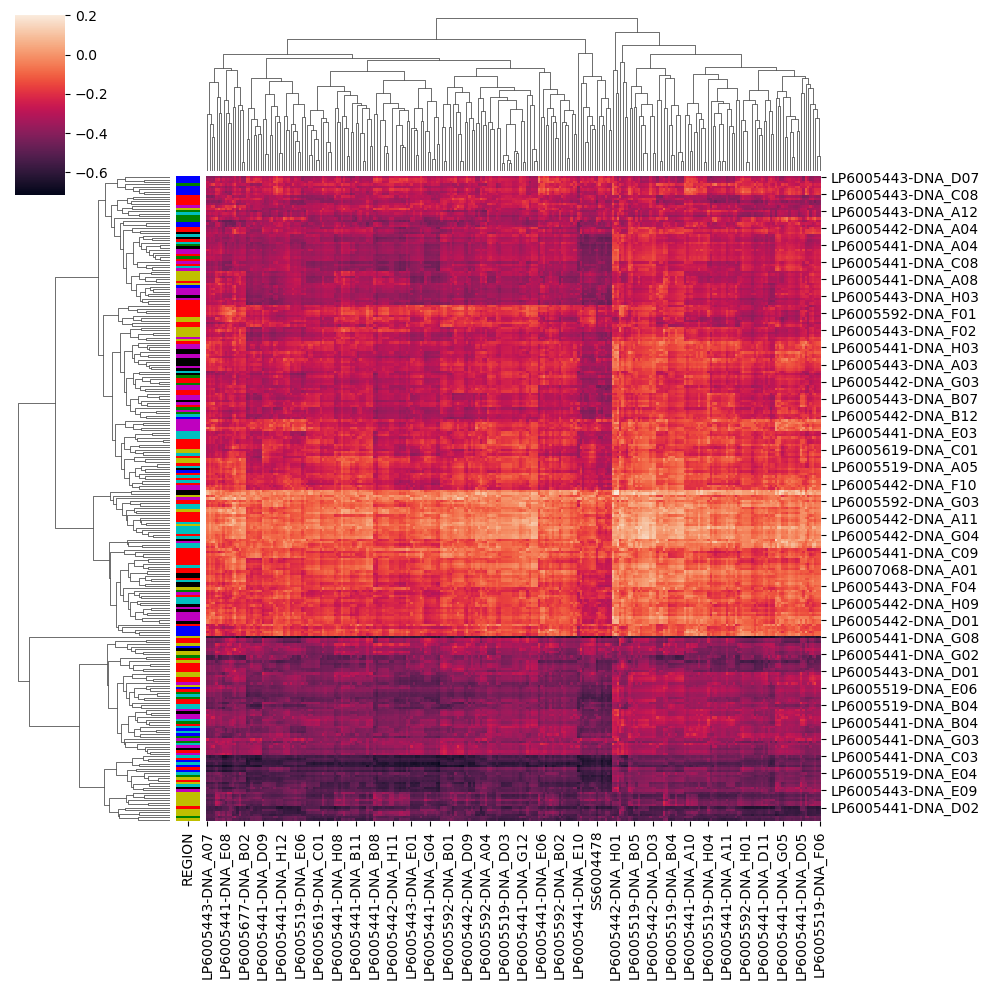

In [49]:
features = features.merge(old_samples.T, left_index=True, right_index=True)
features = features.sort_index()
features

lut = dict(zip(features['REGION'].unique(), "rbgymck"))
row_colors = features['REGION'].map(lut)
#sns.clustermap(old_samples.T, row_colors=row_colors)
sns.clustermap(d, row_colors=row_colors)


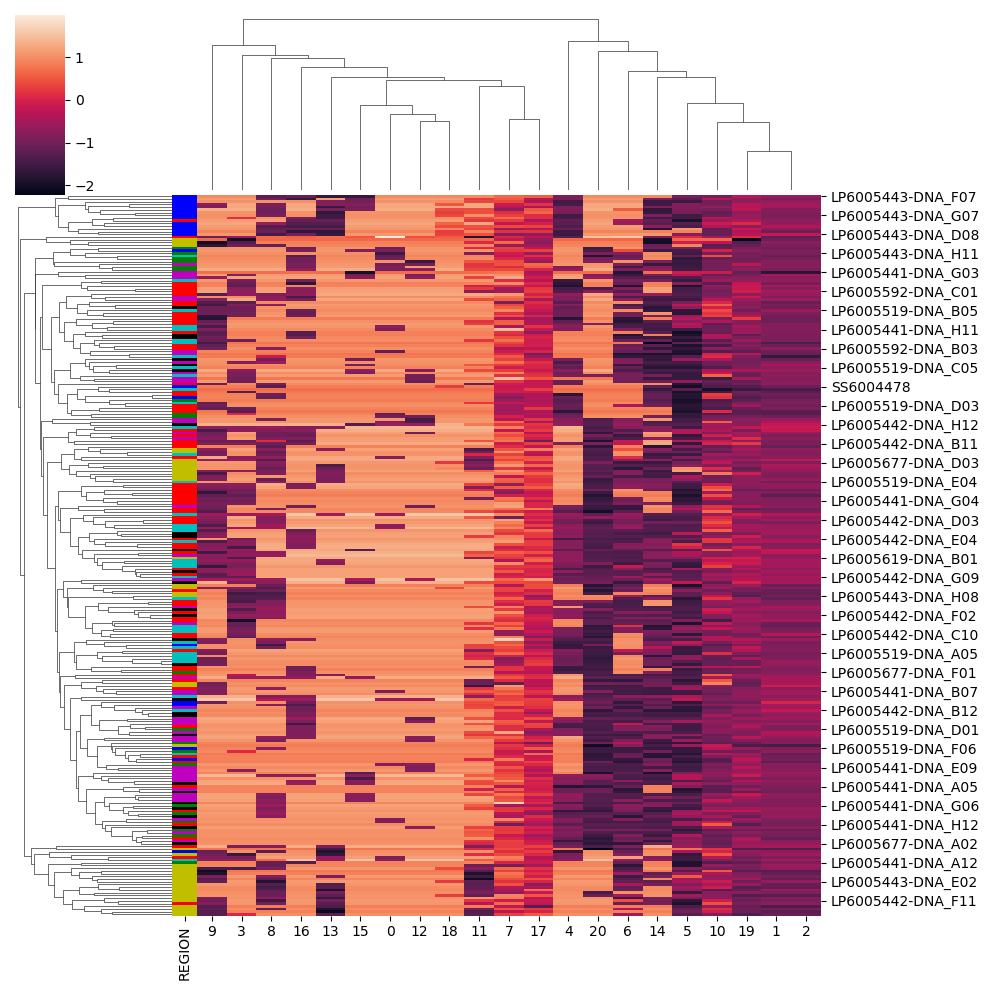

In [50]:
lut = dict(zip(features['REGION'].unique(), "rbgymck"))
row_colors = features['REGION'].map(lut)
#sns.clustermap(old_samples.T, row_colors=row_colors)
sns.clustermap(old_samples.T, row_colors=row_colors)


/Users/luciabazan/miniconda3/envs/env_cnv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


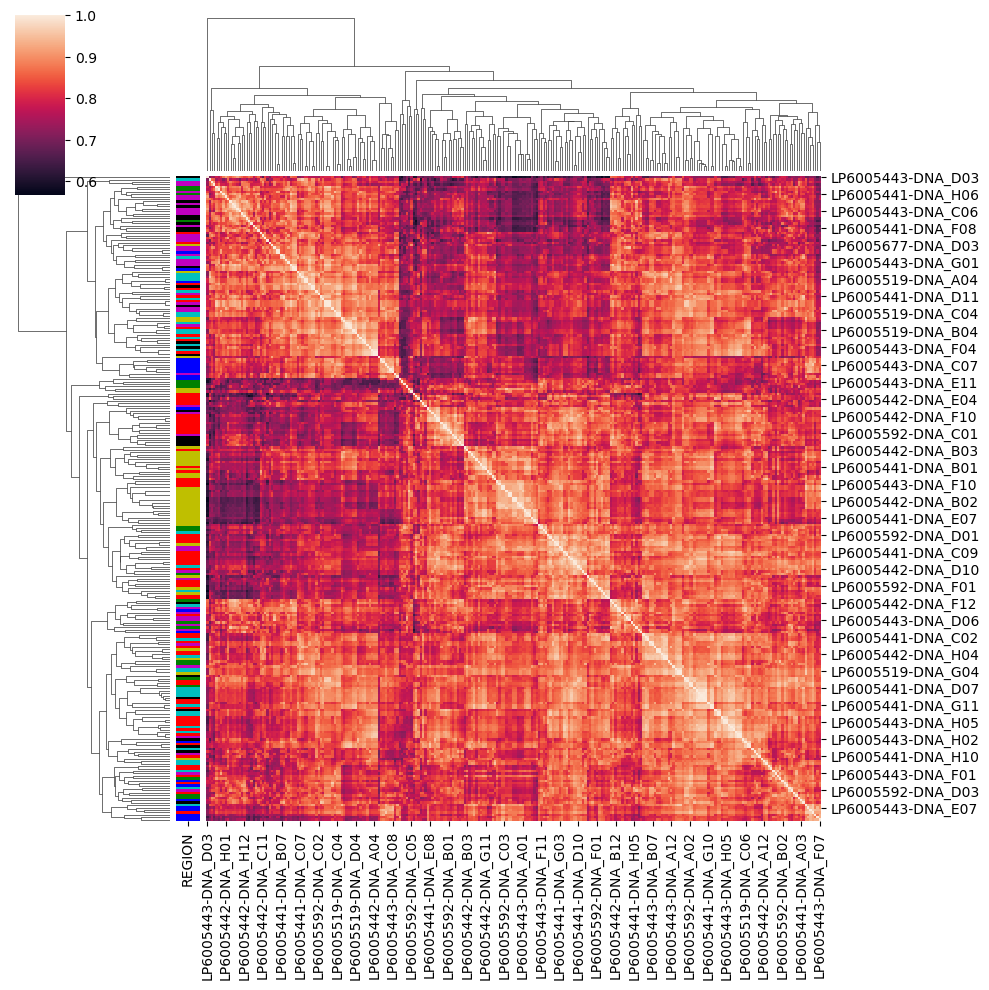

In [51]:
lut = dict(zip(features['REGION'].unique(), "rbgymck"))
row_colors = features['REGION'].map(lut)
#sns.clustermap(old_samples.T, row_colors=row_colors)
sns.clustermap(new_samples.corr(method='kendall'), row_colors=row_colors)

In [52]:
new_samples.corr(method='spearman')

,LP6005441-DNA_A01,LP6005441-DNA_A03,LP6005441-DNA_A04,LP6005441-DNA_A05,LP6005441-DNA_A06,LP6005441-DNA_A08,LP6005441-DNA_A09,LP6005441-DNA_A10,LP6005441-DNA_A11,LP6005441-DNA_A12,...,LP6005677-DNA_D03,LP6005677-DNA_E01,LP6005677-DNA_F01,LP6005677-DNA_G01,LP6007068-DNA_A01,LP6007069-DNA_A01,SS6004471,SS6004477,SS6004478,SS6004480
LP6005441-DNA_A01,1.000000,0.921404,0.897707,0.952277,0.885855,0.853178,0.918337,0.892914,0.855184,0.890161,...,0.832059,0.921968,0.932364,0.953429,0.890415,0.857169,0.899759,0.976083,0.909597,0.834185
LP6005441-DNA_A03,0.921404,1.000000,0.918906,0.906814,0.860636,0.838903,0.867997,0.914090,0.900554,0.894534,...,0.884302,0.950193,0.941821,0.918887,0.894617,0.877141,0.854878,0.907259,0.925492,0.830190
LP6005441-DNA_A04,0.897707,0.918906,1.000000,0.837464,0.789067,0.805949,0.827837,0.898870,0.866145,0.835863,...,0.870359,0.879990,0.931627,0.888209,0.801806,0.862313,0.810787,0.875996,0.861701,0.847248
LP6005441-DNA_A05,0.952277,0.906814,0.837464,1.000000,0.935952,0.873438,0.905439,0.856557,0.826990,0.931052,...,0.781670,0.935895,0.927283,0.943790,0.876555,0.857363,0.880884,0.939098,0.871556,0.801897
LP6005441-DNA_A06,0.885855,0.860636,0.789067,0.935952,1.000000,0.844953,0.914492,0.799645,0.901542,0.916552,...,0.771429,0.865914,0.871207,0.933269,0.935873,0.838645,0.937297,0.867985,0.853152,0.831185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LP6007069-DNA_A01,0.857169,0.877141,0.862313,0.857363,0.838645,0.884761,0.906376,0.829067,0.837295,0.902273,...,0.906261,0.898895,0.892307,0.903439,0.838176,1.000000,0.839828,0.902508,0.934511,0.868838
SS6004471,0.899759,0.854878,0.810787,0.880884,0.937297,0.892680,0.892560,0.801389,0.889120,0.878408,...,0.871701,0.822109,0.852816,0.927365,0.973909,0.839828,1.000000,0.869873,0.865770,0.838990
SS6004477,0.976083,0.907259,0.875996,0.939098,0.867985,0.835605,0.940023,0.868095,0.825220,0.882833,...,0.824859,0.945956,0.913811,0.939515,0.856562,0.902508,0.869873,1.000000,0.934746,0.811955
SS6004478,0.909597,0.925492,0.861701,0.871556,0.853152,0.831091,0.885545,0.817707,0.871069,0.908058,...,0.852755,0.931622,0.894609,0.918353,0.902416,0.934511,0.865770,0.934746,1.000000,0.812590


/Users/luciabazan/miniconda3/envs/env_cnv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

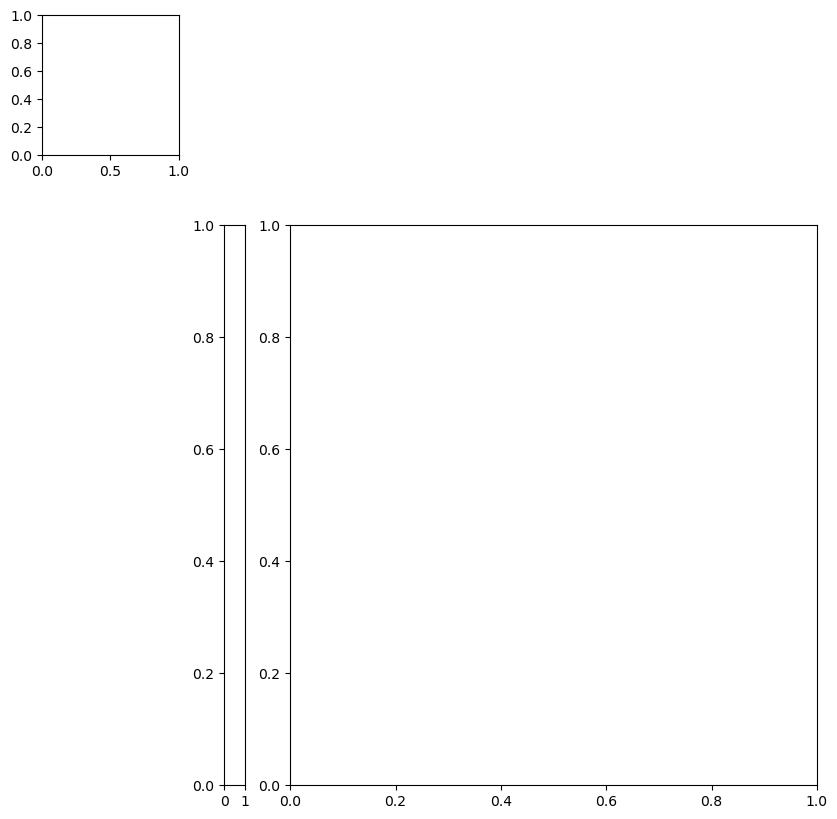

In [53]:
p = cnv.iloc[:,3:273]
lut = dict(zip(features['REGION'].unique(), "rbgymck"))
row_colors = features['REGION'].map(lut)
#sns.clustermap(old_samples.T, row_colors=row_colors)
sns.clustermap(p.T.corr(), row_colors=row_colors)